In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [4]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import vits, melgan, hifigan
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from malaya_speech.train.loss import calculate_2d_loss, calculate_3d_loss

In [5]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [6]:
wav['wav'].shape

(1, 104448)

In [7]:
config = vits.Config(mel = 80, vocabs = 66)

In [8]:
model = vits.Model(config)

In [9]:
i = tf.convert_to_tensor([data['text_ids'][0],data['text_ids'][0]])
i_lengths = tf.convert_to_tensor([data['len_text_ids'][0,0], data['len_text_ids'][0,0]])
mel_outputs = tf.convert_to_tensor([data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]])
mel_lengths = tf.convert_to_tensor([408,408])
wavs = tf.convert_to_tensor([wav['wav'].astype(np.float32)] * 2)[:,0]
wavs.shape

TensorShape([Dimension(2), Dimension(104448)])

In [10]:
losses, attn, latent, z_slice, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor: id=47876, shape=(2, 73, 80), dtype=float32, numpy=
 array([[[-1.0067103e+00,  4.1941941e-01, -5.9442782e-01, ...,
          -5.1517397e-01, -2.2544839e+00, -3.3677816e+00],
         [-8.0316818e-01,  9.4373114e-02, -1.3398325e-01, ...,
           2.2277814e-01, -2.1512942e+00, -2.2439926e+00],
         [-1.6446664e+00, -4.8940383e-02, -5.2111655e-02, ...,
           2.2060858e-01, -8.0820024e-01, -3.4676313e-02],
         ...,
         [-1.4718471e+00,  5.6009209e-01, -6.5965056e-02, ...,
           4.5213871e-02,  8.1903338e-02,  6.3951564e-01],
         [ 6.4426255e-01,  1.0596663e-01, -2.1945757e-01, ...,
          -3.3138174e-01, -2.7802694e+00,  1.0784688e+00],
         [-7.0219982e-01, -5.2547939e-02, -2.8690809e-01, ...,
          -3.3735195e-01, -4.0396428e+00, -3.2347929e+00]],
 
        [[-1.0203612e-01,  1.7979428e-01, -3.5196185e-01, ...,
           4.9447216e-02,  1.0848045e-03,  4.4467068e-01],
         [-1.7280904e+00,  2.4587521e-01,  1.4792499e-01, ...,
  

In [12]:
losses

{'kl': <tf.Tensor: id=41539, shape=(), dtype=float32, numpy=2024.1184>,
 'durloss': <tf.Tensor: id=41738, shape=(), dtype=float32, numpy=0.3085085>}

In [13]:
latent.shape

TensorShape([Dimension(2), Dimension(408), Dimension(80)])

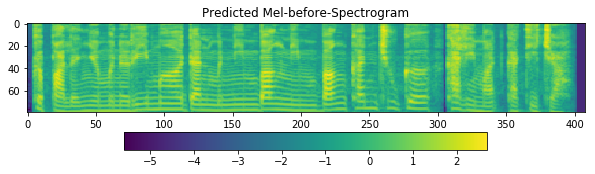

In [14]:
mel_outputs_ = np.reshape(mel_outputs[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

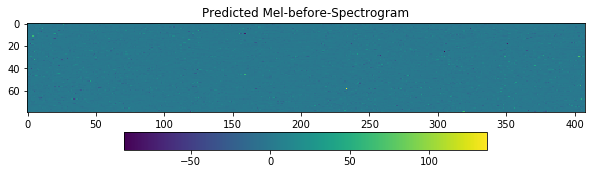

In [15]:
mel_outputs_ = np.reshape(latent[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [16]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-5, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9)

In [ ]:
for k in range(500):
    with tf.GradientTape() as tape:
        losses, attn, latent, mel_hat, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
        loss = losses['kl'] + losses['durloss']
    print(k, losses)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

0 {'kl': <tf.Tensor: id=72327, shape=(), dtype=float32, numpy=2073.8032>, 'durloss': <tf.Tensor: id=72421, shape=(), dtype=float32, numpy=0.35065535>}
1 {'kl': <tf.Tensor: id=126050, shape=(), dtype=float32, numpy=1257.8646>, 'durloss': <tf.Tensor: id=126144, shape=(), dtype=float32, numpy=0.30002666>}
2 {'kl': <tf.Tensor: id=166473, shape=(), dtype=float32, numpy=920.01044>, 'durloss': <tf.Tensor: id=166567, shape=(), dtype=float32, numpy=0.21562807>}
3 {'kl': <tf.Tensor: id=206896, shape=(), dtype=float32, numpy=732.3733>, 'durloss': <tf.Tensor: id=206990, shape=(), dtype=float32, numpy=0.17291832>}
4 {'kl': <tf.Tensor: id=247319, shape=(), dtype=float32, numpy=628.11743>, 'durloss': <tf.Tensor: id=247413, shape=(), dtype=float32, numpy=0.21990623>}
5 {'kl': <tf.Tensor: id=287742, shape=(), dtype=float32, numpy=535.05493>, 'durloss': <tf.Tensor: id=287836, shape=(), dtype=float32, numpy=0.2036035>}
6 {'kl': <tf.Tensor: id=328165, shape=(), dtype=float32, numpy=474.55588>, 'durloss': 

In [ ]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

In [ ]:
mel_outputs_ = np.reshape(mel_[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    attn_out[0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
# saver = tf.train.Saver()
# saver.save(sess, 'test/model.ckpt')